# Imports and Functions

In [1]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [31]:
from itertools import combinations

In [141]:
def DistanceCovariance(model, mfv_dataset, labels=None, shuffle=False, silent=False):
    """# Distance Covariance
    Compute the distance in the MFS and MLS
    - mfv_dataset: (N,13)
    - labels: (N,...) ?"""
    from numpy import vstack, array
    from numpy.linalg import norm
    from tqdm.auto import tqdm
    assert mfv_dataset.shape[1] == 13
    if labels is None:
        neighborhood_labels = None
    else:
        assert labels.shape[0] == mfv_dataset.shape[0]
        neighborhood_labels = []
    neighborhood_distances = []
    progress = tqdm
    if silent:
        progress = lambda x: x
    for cell_index in progress(range(mfv_dataset.shape[0])):
        source_cell = mfv_dataset[[cell_index],:]
        destination_cells = vstack([mfv_dataset[(cell_index+1):,:]])
        mfv_distance = norm((destination_cells - source_cell), axis=-1)
        mlv_distance = norm((model.encoder(destination_cells)-model.encoder(source_cell)), axis=-1)
        v_distances = list(zip(mfv_distance, mlv_distance))
        if labels is not None:
            neighborhood_labels.extend([labels[cell_index,...]] * len(v_distances))
        for distance in v_distances:
            neighborhood_distances.append(distance)
    neighborhood_distances = array(neighborhood_distances)
    if labels is not None:
        neighborhood_labels = array(neighborhood_labels)
    if shuffle:
        from numpy.random import permutation as permute
        permutation = permute(neighborhood_distances.shape[0])
        neighborhood_distances = neighborhood_distances[permutation,...]
        if labels is not None:
            neighborhood_labels = neighborhood_labels[permutation,...]
    return neighborhood_distances, neighborhood_labels

In [65]:
def interpolate_shape_data(s_a, s_b, M=10, p=0, progress=True):
    N = M + 1
    assert N > 0
    assert isinstance(N, int)
    source = s_a
    destination = s_b
    assert len(source.shape) == 1
    assert len(destination.shape) == 1
    assert source.shape[0] == destination.shape[0]
    iteration_powers = np.array([2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1])
    assert source.shape[0] == iteration_powers.shape[0]
    
    ps = [p,p,p]
    if progress:
        ps = [p,p+1,p+2]

    s0_data = source[iteration_powers == 0]
    s1_data = source[iteration_powers == 1]
    s2_data = source[iteration_powers == 2]
    d0_data = destination[iteration_powers == 0]
    d1_data = destination[iteration_powers == 1]
    d2_data = destination[iteration_powers == 2]

    _sum = lambda p, N: np.sum([i ** p for i in range(1,N+1)])
#     alpha_N = (d0_data - s0_data)/N
#     beta_N  = (d1_data - s1_data)/((N*(N+1))/2)
#     gamma_N = (d2_data - s2_data)/((N*(N+1)*(2*N+1))/6)
    alpha_N = (d0_data - s0_data) / _sum(ps[0],N)
    beta_N  = (d1_data - s1_data) / _sum(ps[1],N)
    gamma_N = (d2_data - s2_data) / _sum(ps[2],N)

    i0_data = np.zeros((N+1, s0_data.shape[0]))
    i0_data[0,...] = s0_data
    i1_data = np.zeros((N+1, s1_data.shape[0]))
    i1_data[0,...] = s1_data
    i2_data = np.zeros((N+1, s2_data.shape[0]))
    i2_data[0,...] = s2_data
    _t = 0
    for i in range(1,1+N):
        j = i
        i0_data[j,...] = i0_data[j-1,...] + alpha_N * (i ** ps[0])
        i1_data[j,...] = i1_data[j-1,...] + beta_N * (i ** (ps[1]))
        i2_data[j,...] = i2_data[j-1,...] + gamma_N * (i ** ps[2])
    _data = np.hstack([i0_data,i1_data,i2_data])[:,np.argsort(np.argsort(iteration_powers))]
    return _data

# Runtime Parameters

In [7]:
SAVE_EXTRAS = False

In [166]:
g_Base = lambda *args: DIR_ROOT + "Figures/"
g_Interpolation = 25*8

# Setup

In [112]:
model, dataset = load_aae_and_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [197]:
_T = 500

In [199]:
data = []
for (a,b) in combinations(range(100),2):
    source = dataset.dataset[a,...]
    destination = dataset.dataset[b,...]
    data.append(interpolate_shape_data(source, destination, M=g_Interpolation, p=-1))
data = np.vstack(data)

In [201]:
output = DistanceCovariance(model, data[:_T,...], np.resize(np.arange(g_Interpolation),data.shape[0])[:_T,...])

  0%|          | 0/500 [00:00<?, ?it/s]

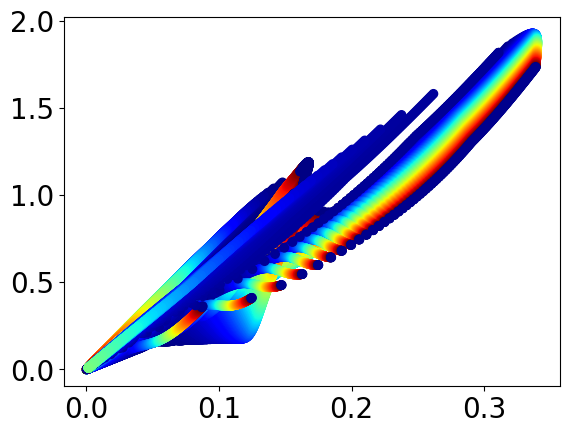

In [202]:
plt.scatter2d(output[0], c=output[1], cmap='jet')
_ = _

In [203]:
data = []
for (a,b) in combinations(range(100),2):
    source = dataset.dataset[a,...]
    destination = dataset.dataset[b,...]
    data.append(interpolate_shape_data(source, destination, M=g_Interpolation, p=0, progress=False))
data = np.vstack(data)

In [204]:
output = DistanceCovariance(model, data[:_T,...], np.resize(np.arange(g_Interpolation),data.shape[0])[:_T,...])

  0%|          | 0/500 [00:00<?, ?it/s]

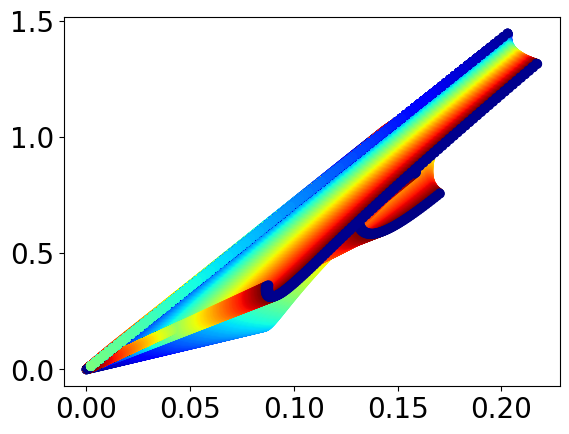

In [205]:
plt.scatter2d(output[0], c=output[1], cmap='jet')
_ = _

In [206]:
data = []
for (a,b) in combinations(range(100),2):
    source = dataset.dataset[a,...]
    destination = dataset.dataset[b,...]
    data.append(interpolate_shape_data(source, destination, M=g_Interpolation, p=0))
data = np.vstack(data)

In [208]:
output = DistanceCovariance(model, data[:_T,...], np.resize(np.arange(g_Interpolation),data.shape[0])[:_T,...])

  0%|          | 0/500 [00:00<?, ?it/s]

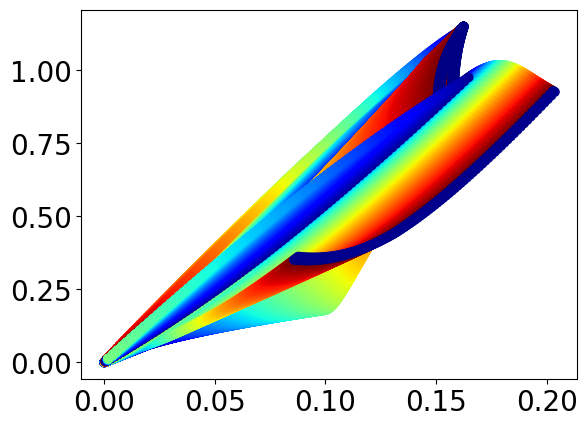

In [209]:
plt.scatter2d(output[0], c=output[1], cmap='jet')
_ = _

In [ ]:
output = DistanceCovariance(model, data)

# Plots

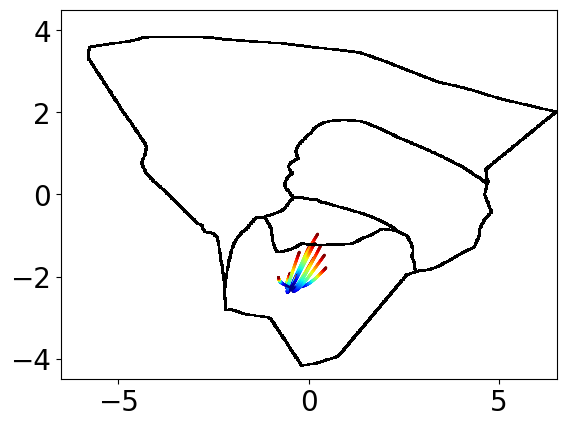

In [179]:
for _M in range(1,20):
    _N = 0
    source = dataset.dataset[_N,...]
    destination = dataset.dataset[_M,...]

    out = interpolate_shape_data(source, destination, M=g_Interpolation, p=-1)
    out_mlv = model.encoder(out).numpy()
    R = np.linalg.norm(out_mlv[-1,...] - out_mlv[0,...])
    if R < 1.5:
        plt.scatter2d(out_mlv, s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary()

In [260]:
_P = 0
_PROGRESS = True

  0%|          | 0/202 [00:00<?, ?it/s]

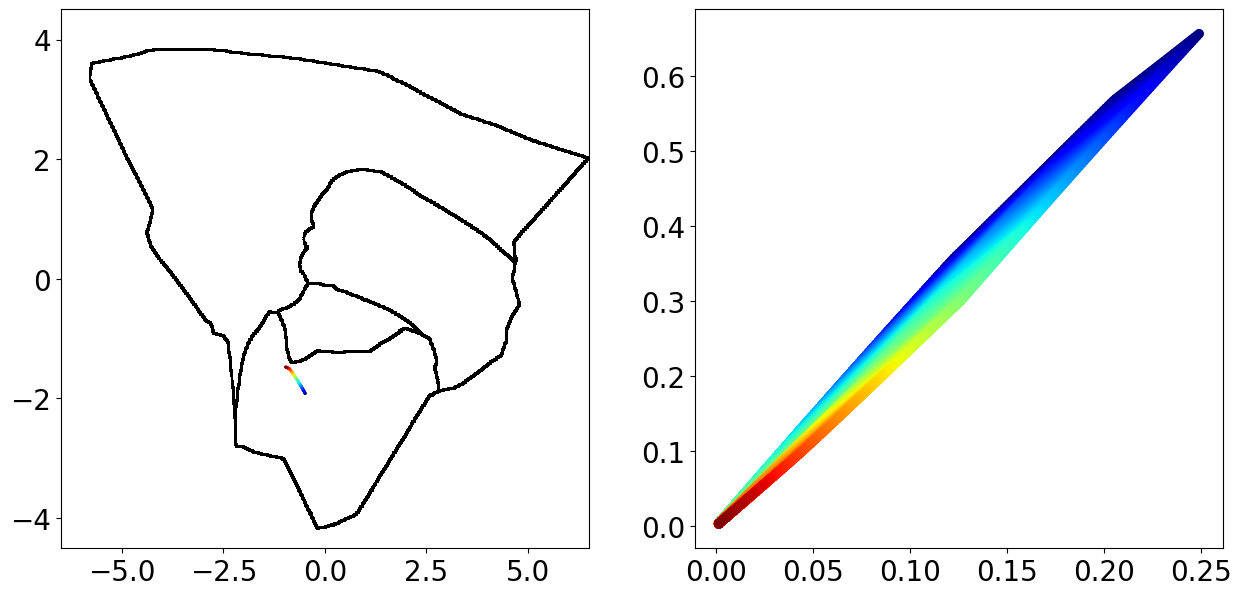

In [261]:
_N,_M = (2,23)

fig, ax = plt.subplots(1,2, figsize=(15,7))
source = dataset.dataset[_N,...]
destination = dataset.dataset[_M,...]

out = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
out_mlv = model.encoder(out).numpy()
ax[0].scatter(out_mlv[...,0], out_mlv[...,1], s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary(_plt=ax[0])

interpolated = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
distances, _labels = DistanceCovariance(model, interpolated, np.arange(interpolated.shape[0]))
ax[1].scatter(distances[...,0], distances[...,1], c=_labels, cmap='jet')

_ = _

  0%|          | 0/202 [00:00<?, ?it/s]

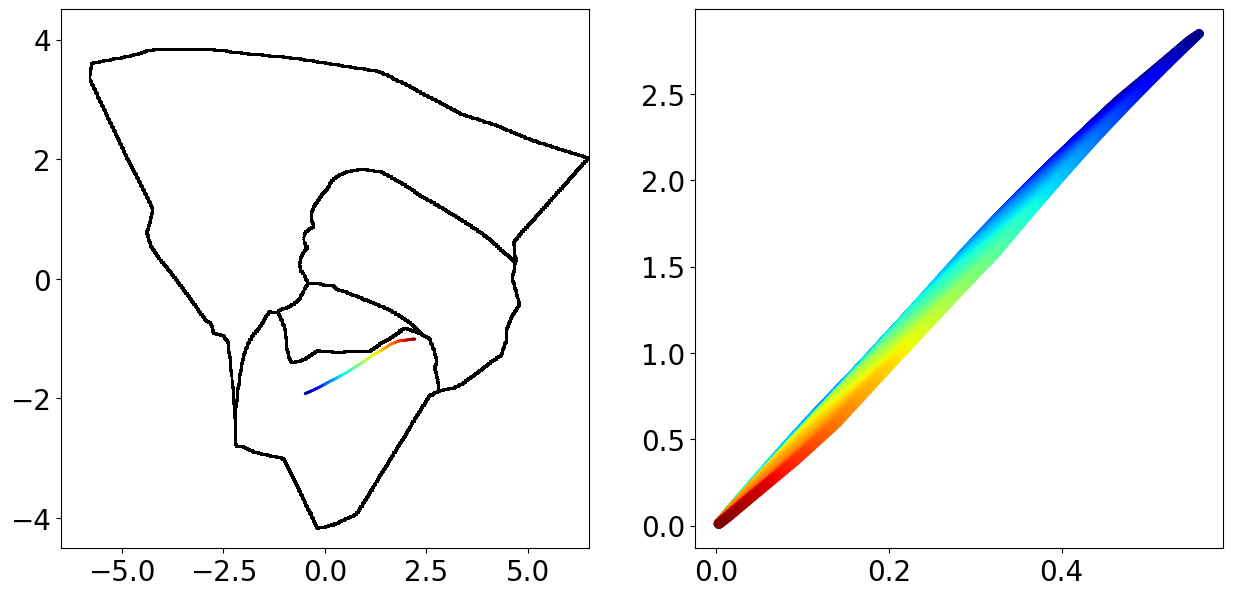

In [262]:
_N,_M = (2,24)

fig, ax = plt.subplots(1,2, figsize=(15,7))
source = dataset.dataset[_N,...]
destination = dataset.dataset[_M,...]

out = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
out_mlv = model.encoder(out).numpy()
ax[0].scatter(out_mlv[...,0], out_mlv[...,1], s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary(_plt=ax[0])

interpolated = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
distances, _labels = DistanceCovariance(model, interpolated, np.arange(interpolated.shape[0]))
ax[1].scatter(distances[...,0], distances[...,1], c=_labels, cmap='jet')

_ = _

  0%|          | 0/202 [00:00<?, ?it/s]

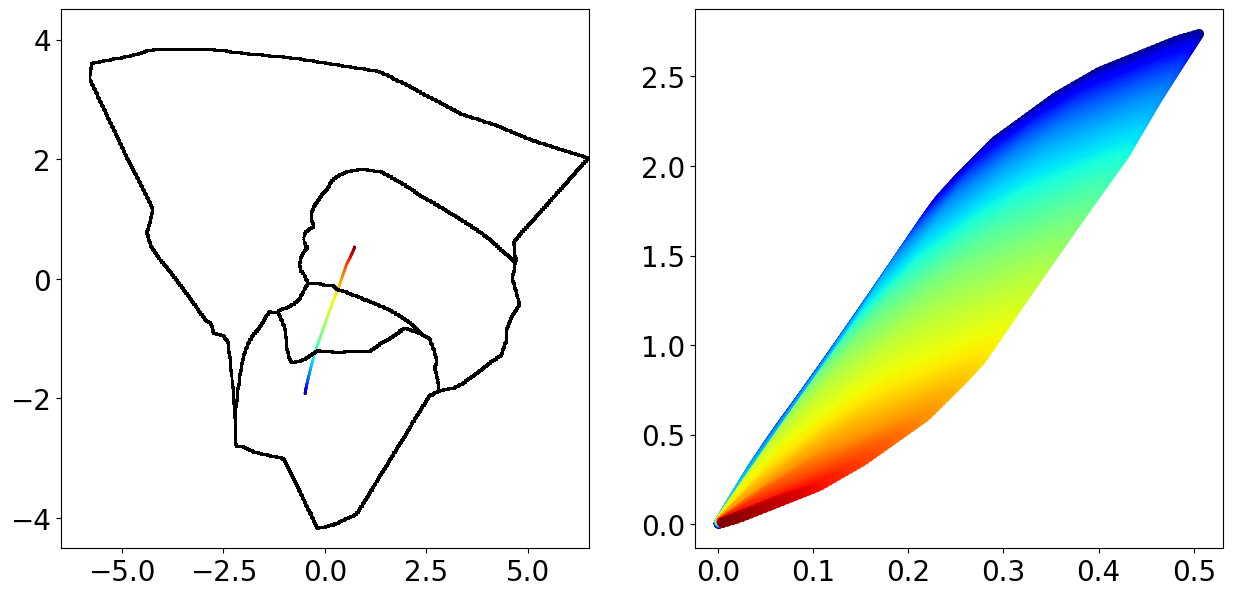

In [263]:
_N,_M = (2,25)

fig, ax = plt.subplots(1,2, figsize=(15,7))
source = dataset.dataset[_N,...]
destination = dataset.dataset[_M,...]

out = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
out_mlv = model.encoder(out).numpy()
ax[0].scatter(out_mlv[...,0], out_mlv[...,1], s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary(_plt=ax[0])

interpolated = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
distances, _labels = DistanceCovariance(model, interpolated, np.arange(interpolated.shape[0]))
ax[1].scatter(distances[...,0], distances[...,1], c=_labels, cmap='jet')

_ = _

  0%|          | 0/202 [00:00<?, ?it/s]

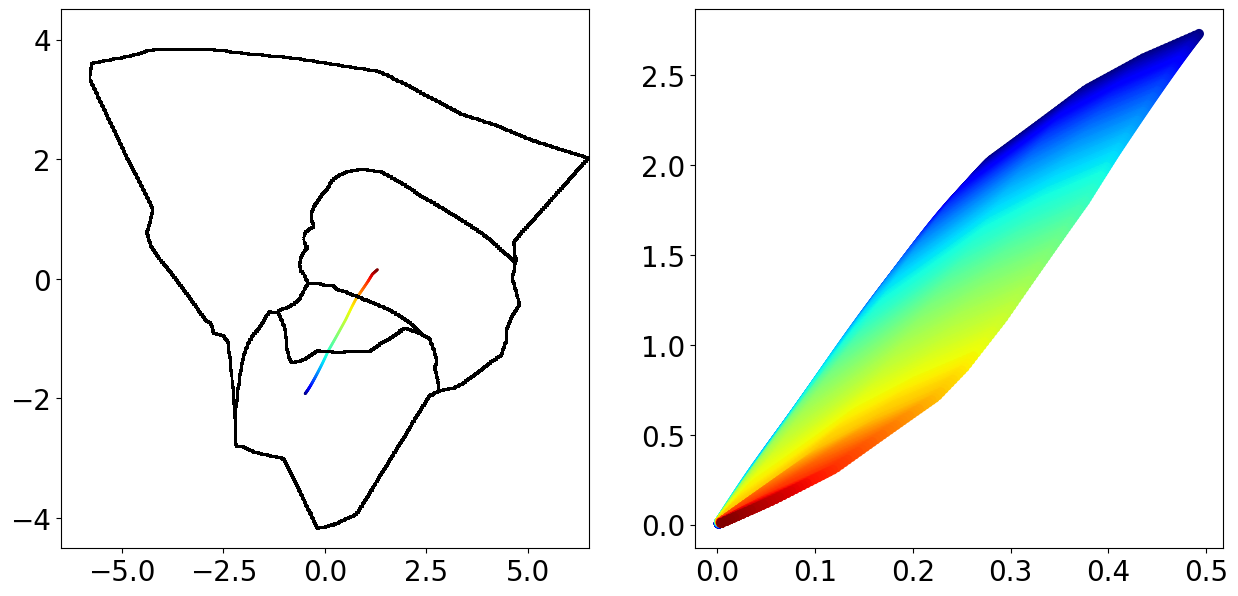

In [264]:
_N,_M = (2,26)

fig, ax = plt.subplots(1,2, figsize=(15,7))
source = dataset.dataset[_N,...]
destination = dataset.dataset[_M,...]

out = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
out_mlv = model.encoder(out).numpy()
ax[0].scatter(out_mlv[...,0], out_mlv[...,1], s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary(_plt=ax[0])

interpolated = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
distances, _labels = DistanceCovariance(model, interpolated, np.arange(interpolated.shape[0]))
ax[1].scatter(distances[...,0], distances[...,1], c=_labels, cmap='jet')

_ = _

  0%|          | 0/202 [00:00<?, ?it/s]

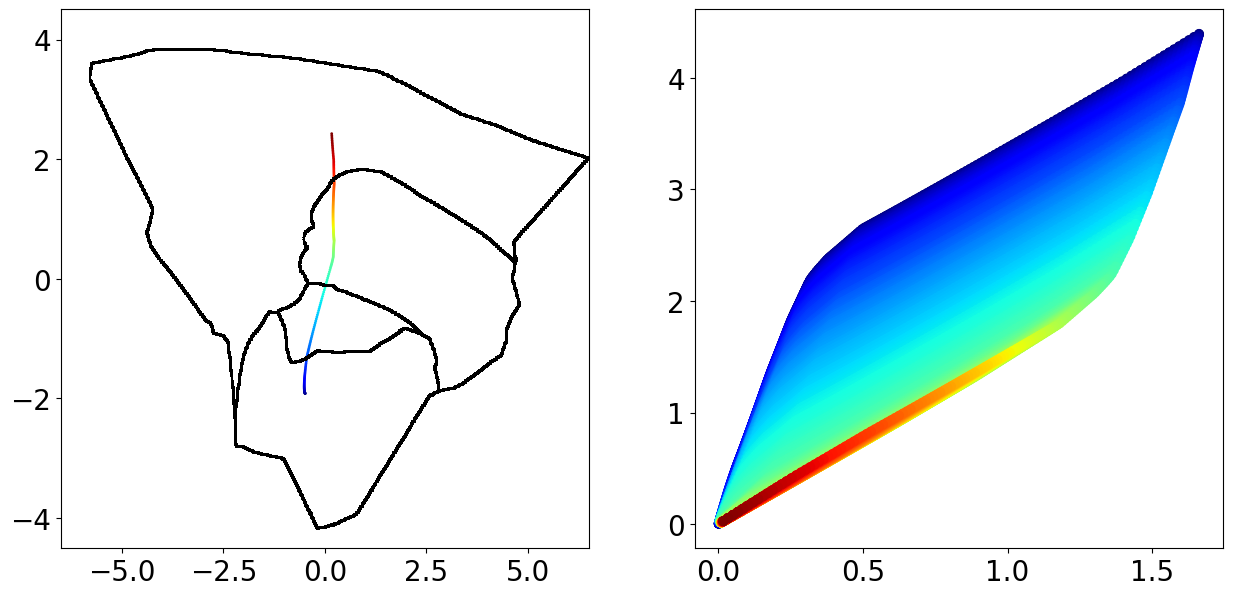

In [265]:
_N,_M = (2,27)

fig, ax = plt.subplots(1,2, figsize=(15,7))
source = dataset.dataset[_N,...]
destination = dataset.dataset[_M,...]

out = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
out_mlv = model.encoder(out).numpy()
ax[0].scatter(out_mlv[...,0], out_mlv[...,1], s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary(_plt=ax[0])

interpolated = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
distances, _labels = DistanceCovariance(model, interpolated, np.arange(interpolated.shape[0]))
ax[1].scatter(distances[...,0], distances[...,1], c=_labels, cmap='jet')

_ = _

  0%|          | 0/202 [00:00<?, ?it/s]

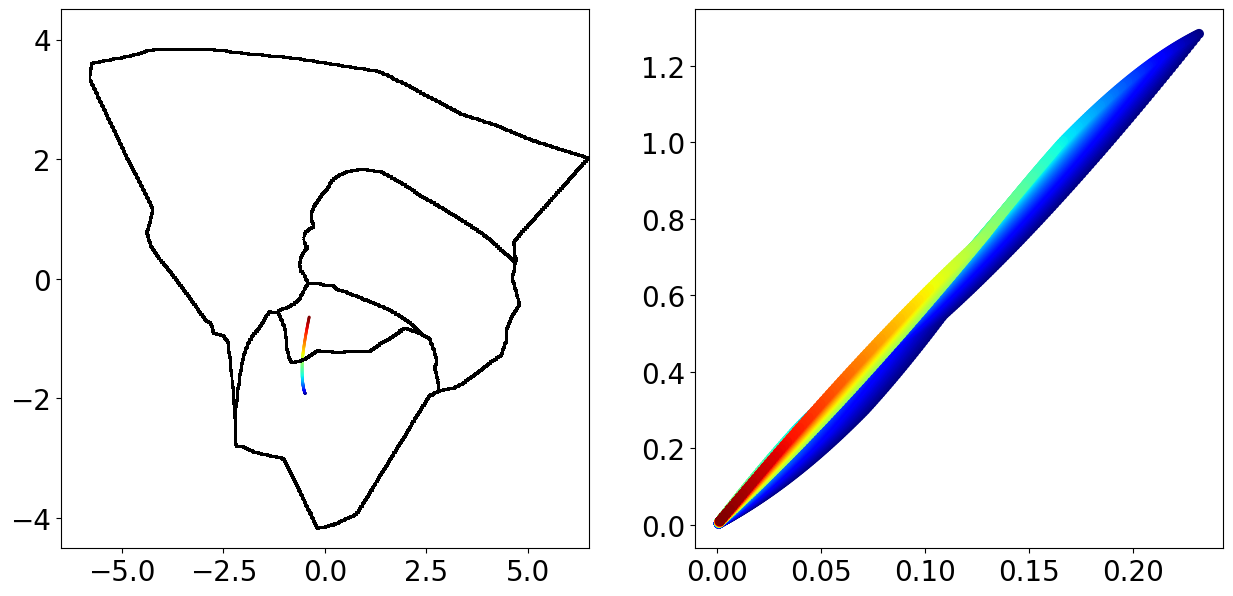

In [266]:
_N,_M = (2,28)

fig, ax = plt.subplots(1,2, figsize=(15,7))
source = dataset.dataset[_N,...]
destination = dataset.dataset[_M,...]

out = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
out_mlv = model.encoder(out).numpy()
ax[0].scatter(out_mlv[...,0], out_mlv[...,1], s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary(_plt=ax[0])

interpolated = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
distances, _labels = DistanceCovariance(model, interpolated, np.arange(interpolated.shape[0]))
ax[1].scatter(distances[...,0], distances[...,1], c=_labels, cmap='jet')

_ = _

  0%|          | 0/202 [00:00<?, ?it/s]

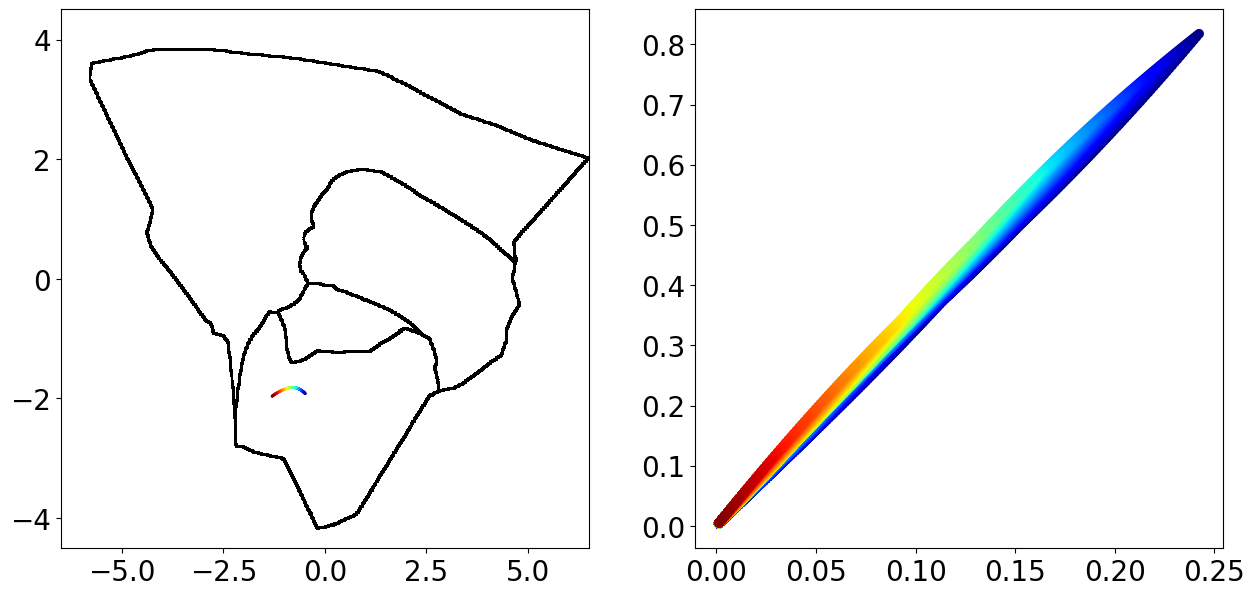

In [267]:
_N,_M = (2,29)

fig, ax = plt.subplots(1,2, figsize=(15,7))
source = dataset.dataset[_N,...]
destination = dataset.dataset[_M,...]

out = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
out_mlv = model.encoder(out).numpy()
ax[0].scatter(out_mlv[...,0], out_mlv[...,1], s=1, c=range(out_mlv.shape[0]), cmap='jet')
plt.apply_boundary(_plt=ax[0])

interpolated = interpolate_shape_data(source, destination, M=g_Interpolation, p=_P, progress=_PROGRESS)
distances, _labels = DistanceCovariance(model, interpolated, np.arange(interpolated.shape[0]))
ax[1].scatter(distances[...,0], distances[...,1], c=_labels, cmap='jet')

_ = _

# END